# ML - Analiza Skupień

## 1. Przygotować zbiór danych do pracy

Naszym zbiorem danych, dla którego wykonamy zadanie będzie zbiór obrazków o wymiarach 8x8 przedstawiających cyfry.

In [12]:
from sklearn.datasets import load_digits

digits = load_digits()
digits_data = digits.data
digits_target = digits.target

digits_data.shape

(1797, 64)

In [13]:
import matplotlib.pyplot as plt

# funkcja sluzy do wyswietlania obrazkow
# x i y to ilość obrazków w poziomie i w pionie
def printImgs(data, x, y):
    ig, ax = plt.subplots(y, x, figsize=(8, 3))
    imgs = data.reshape(x*y, 8, 8)
    for axi, img in zip(ax.flat, imgs):
        axi.set(xticks=[], yticks=[])
        axi.imshow(img, cmap=plt.cm.binary)

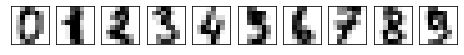

In [27]:
printImgs(digits_data[:10], 10, 1)

## 2. Popularne algorymty w analizie skupień

Uczenie nienadzorowane – to rodzaj uczenia maszynowego, którego zadaniem jest odkrywaniem w zbiorze danych wzorców bez wcześniej istniejących etykiet i przy minimalnej ingerencji człowieka. Uczenie nienadzorowane zakłada brak obecności oczekiwanego wyjścia w danych uczących.

Dwie główne metody stosowane w uczeniu nienadzorowanym to analiza składowych głównych oraz **analiza skupień**. Analiza skupień jest wykorzystywana w celu grupowania lub segmentowania zestawów danych ze wspólnymi atrybutami w celu ekstrapolacji występujących w nich zależności. Analiza skupień identyfikuje podobieństwa w danych i pozwala na grupowanie danych, które nie zostały oznaczone, sklasyfikowane ani skategoryzowane. Ponieważ analiza skupień bazuje na obecności lub braku takich podobieństw w nowej danych, może być wykorzystana aby wykryć nietypowe dane, które nie pasują do żadnej grupy. 

Jest to przegląd trzech najbardziej popularnych metod grupowania i charakterystyka, do jakich rodzajów sytuacji każda z nich nadaje się najlepiej.

### K-Means Clustering - wyjasnienie

Algorytm K-Means szuka z góry **określonej liczby klastrów** w nieoznaczonym wielowymiarowym zestawie danych. Osiąga to poprzez prostą koncepcję tego, jak wygląda optymalne grupowanie. "Centrum klastra” jest średnią arytmetyczną wszystkich punktów należących do klastra. Każdy punkt jest bliżej własnego centrum klastrów niż innych centrów klastrów. Wygenerujmy prosty zbiór danych:

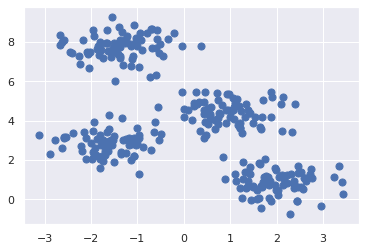

In [43]:
from sklearn.datasets import make_blobs
X, y_true = make_blobs(n_samples=300, centers=4, cluster_std=0.60, random_state=0)
plt.scatter(X[:, 0], X[:, 1], s=50);

Na oko stosunkowo łatwo można wyróżnić cztery klastry. Algorytm K-Means robi to automatycznie:

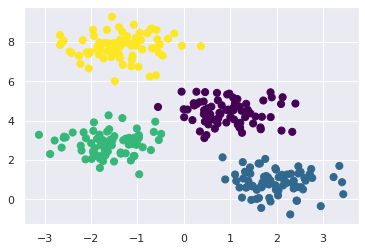

In [46]:
from sklearn.cluster import KMeans

kmeans_dots = KMeans(n_clusters=4)
kmeans_dots.fit(X)
y_kmeans = kmeans_dots.predict(X)

plt.scatter(X[:, 0], X[:, 1], c=y_kmeans, s=50, cmap='viridis')
centers = kmeans.cluster_centers_

Proste prawda!. Jak to działa?

W skrócie, podejście to wykorzystuje algorytm: oczekiwanie i maksymalizacja (E-M):

1. Zgadnij niektóre centra klastrowe
* Powtarzaj poniższe kroki, aż punkty zbiegną się:
    * krok E: przypisz punkty do najbliższego centrum klastra
    * krok M: ustaw centra skupienia na ich średnią
    

Krok E (krok oczekiwania) - obejmuje aktualizację naszych oczekiwań, do którego klastra należy każdy punkt

Krok M (krok maksymalizacji) jest tak nazywany, ponieważ wiąże się z maksymalizacją pewnej funkcji sprawności, która określa lokalizację centrów klastrów - w tym przypadku maksymalizacji dokonuje się, przyjmując prosty środek danych w każdym klastrze .

### K-Means Clustering - przykład

Jednym z interesujących zastosowań klastrowania jest kompresja kolorów w obrazach. Na przykład wyobraź sobie, że masz obraz w milionach kolorów. Na większości obrazów duża liczba kolorów nie będzie używana, a wiele pikseli na obrazie będzie miało podobne lub nawet identyczne kolory.

Na przykład rozważmy obraz pokazany na poniższym rysunku, który pochodzi z modułu zestawów danych Scikit-Learn 

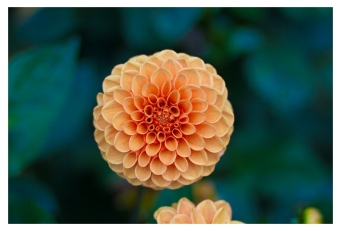

In [58]:
from sklearn.datasets import load_sample_image

china = load_sample_image("flower.jpg")
ax = plt.axes(xticks=[], yticks=[])
ax.imshow(china);

In [53]:
china.shape

(427, 640, 3)

Sam obraz jest przechowywany w trójwymiarowej tablicy rozmiarów (wysokość, szerokość, RGB), zawierającej udziały czerwony / niebieski / zielony jako liczby całkowite od 0 do 255.

Przekształcimy dane do i przeskalujemy kolory tak, aby zawierały się między 0 a 1:

In [55]:
data = china / 255.0 
data = data.reshape(427 * 640, 3)
data.shape

(273280, 3)

Teraz zmniejszmy te kolorory do zaledwie 16 kolorów, używając K-Means grupowania w przestrzeni pikseli. Ponieważ mamy do czynienia z bardzo dużym zestawem danych, użyjemy mini-partii k-średnich.

In [56]:
from sklearn.cluster import MiniBatchKMeans
kmeans = MiniBatchKMeans(16)
kmeans.fit(data)
new_colors = kmeans.cluster_centers_[kmeans.predict(data)]

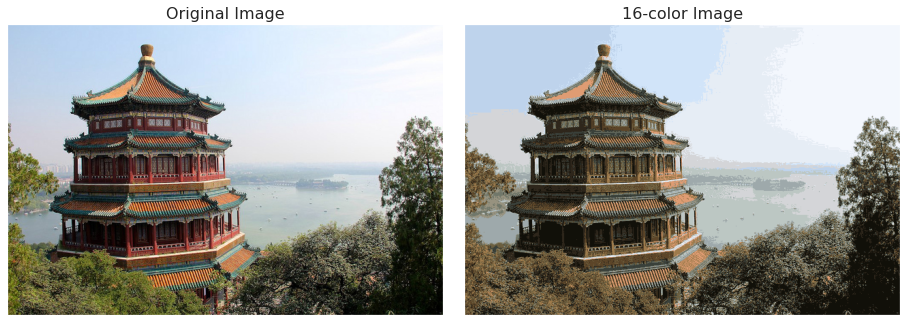

In [57]:
china_recolored = new_colors.reshape(china.shape)

fig, ax = plt.subplots(1, 2, figsize=(16, 6),
                       subplot_kw=dict(xticks=[], yticks=[]))
fig.subplots_adjust(wspace=0.05)
ax[0].imshow(china)
ax[0].set_title('Original Image', size=16)
ax[1].imshow(china_recolored)
ax[1].set_title('16-color Image', size=16);

Rezultatem jest ponowne zabarwienie oryginalnych pikseli, przy czym każdemu pikselowi przypisany jest kolor jego najbliższego centrum skupienia.

### Paritioning Around Medoids - wyjaśnienie

### Paritioning Around Medoids - przykład

### Hierarchical Clustering - wyjaśnienie

### Hierarchical Clustering - przykład

## 3a. Zadanie

Dla zbioru z początku tutoriala wykorzystaj metodę k-means do rozpoznawania cyfr

In [34]:
from sklearn.cluster import KMeans

def fitAndPredictKMeans(data):
    # Stwórz klasyfikator KMeans z odpowiednią ilością klastrów
    kmeans = # todo
    
    # Wytrenuj klasyfikator dla danych i zwróc predycje dla tych danych
    clusters = # todo
    return (kmeans, clusters)

In [35]:
def compareWithTarget(clusters, digits_target):
    labels = np.zeros_like(clusters)
    for i in range(10):
        mask = (clusters == i)
        labels[mask] = mode(digits_target[mask])[0]
    print(accuracy_score(digits_target, labels))

In [36]:
def printCentroids(cluster_centers):
    ig, ax = plt.subplots(2, 5, figsize=(8, 3))
    centers = cluster_centers.reshape(10, 8, 8)
    for axi, center in zip(ax.flat, centers):
        axi.set(xticks=[], yticks=[])
        axi.imshow(center, interpolation='nearest', cmap=plt.cm.binary)

In [38]:
# Wykorzystaj 3 przedstawione wyżej funkcje do sprawdzenia jakości predykcji i narysowaniu centroidów klastrów
# Podpowiedź: centroidy klastrów osiąga się przez kmeans.cluster_centers_

kmeans, clusters = # todo
printCentroids(# todo)
compareWithTarget(# todo)

## 3b. Zadanie

Zrób to samo dla metod grupowania wokół centroidów i aglomeracyjnego klastrowania hierarchicznego.

Dla grupowania wokół centroidów sprawdź rezultaty dla zastosowania różnych metryk (np. "manhattan", "cosine", "euclidean").

Zwróć uwagę, że dla aglomeracyjnego klastrowania hierarchicznego funkcja printCentroids nie ma zastosowania, ponieważ przy tej metodzie nie wyznaczamy centroidów. Tutaj wystarczy wypisanie dokładności rozwiązania.

Krótko skomentuj otrzymane wyniki: